In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

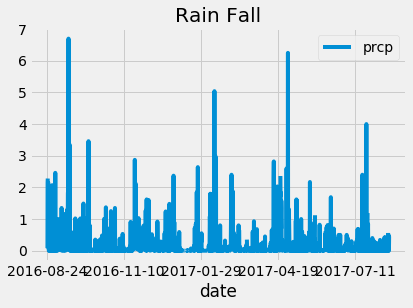

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
lastDate = (session.query(Measurement.date).order_by(Measurement.date.desc()).first())

# Calculate the date 1 year ago from the last data point in the database
lastDate = list(np.ravel(lastDate))[0]

# Perform a query to retrieve the data and precipitation scores
lastDate = dt.datetime.strptime(lastDate, '%Y-%m-%d')
lastYear = int(dt.date.strftime(lastDate, '%Y'))
lastMonth = int(dt.date.strftime(lastDate, '%m'))
lastDay = int(dt.date.strftime(lastDate, '%d'))
yearBefore = dt.date(lastYear, lastMonth, lastDay) - dt.timedelta(days=365)

# Save the query results as a Pandas DataFrame and set the index to the date column
prcpData = (session.query(Measurement.date, Measurement.prcp)
            .filter(Measurement.date > yearBefore)
            .order_by(Measurement.date)
            .all())

# Sort the dataframe by date
prcpTable = pd.DataFrame(prcpData)
prcpTable = prcpTable.set_index('date')
prcpTable = prcpTable.sort_index(ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
prcpTable.plot(title="Rain Fall" )

![precipitation](Images/precipitation.png)

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcpTable.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [17]:
# Design a query to show how many stations are available in this dataset?
stationCount = session.query(Station).count()
print(f"Station Count: {stationCount}")

Station Count: 9


In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stationCount = (session.query(Measurement.station, func.count(Measurement.station))
                .group_by(Measurement.station)
                .order_by(func.count(Measurement.station).desc())
                .all())
stationCount

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [34]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
stationID = stationCount[0][0]

# Most active station
stationName = (session.query(Station.name)
              .filter_by(station = stationID))
stationName = stationName[0][0]
print(f"The most active station is {stationID} {stationName}")

# Lowest Temperature
lowTemp = (session.query(Measurement.tobs)
          .filter(Measurement.station == stationID)
          .order_by(Measurement.tobs.asc())
          .first())
lowTemp = lowTemp[0]
print(f"Lowest Temperature Recorded is {lowTemp} degrees.")

# Highest Temperature
highTemp = (session.query(Measurement.tobs)
          .filter(Measurement.station == stationID)
          .order_by(Measurement.tobs.desc())
          .first())
highTemp = highTemp[0]
print(f"Highest Temperature Recorded is {highTemp} degrees.")

# Average temperature
avgTemp = (session.query(func.avg(Measurement.tobs))
          .filter(Measurement.station == stationID))
avgTemp = '{0:.3}'.format(avgTemp[0][0])
print(f"Average Temperature is {avgTemp} degrees.")


The most active station is USC00519281 WAIHEE 837.5, HI US
Lowest Temperature Recorded is 54.0 degrees.
Highest Temperature Recorded is 85.0 degrees.
Average Temperature is 71.7 degrees.


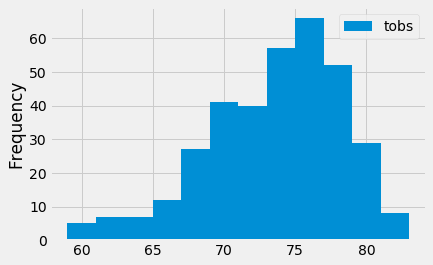

In [36]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tempData = (session.query(Measurement.date, Measurement.tobs)
           .filter(Measurement.date > yearBefore)
           .filter(Measurement.station == stationID)
           .order_by(Measurement.date)
           .all())
tempTable = pd.DataFrame(tempData)
tempTable = tempTable.set_index('date')
tempTable = tempTable.sort_index(ascending=True)
tempTable.plot(kind='hist', bins=12)

![precipitation](Images/station-histogram.png)

In [37]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [42]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = '2017-02-28'
end_date = '2017-03-05'

tripTemps = calc_temps(start_date, end_date)
tripTemps

[(64.0, 72.02777777777777, 78.0)]

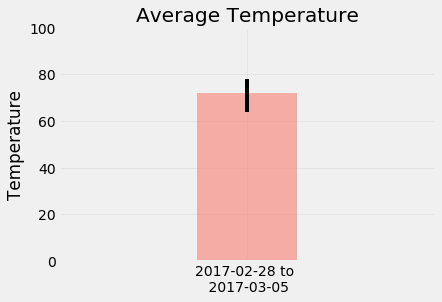

In [46]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
tmin = tripTemps[0][0]
tavg = tripTemps[0][1]
tmax = tripTemps[0][2]

emin = tavg - tmin
emax = tmax - tavg

ebar = np.array([[emin],[emax]])
tripDates = '2017-02-28 to \n 2017-03-05'
plt.bar(tripDates, tavg, yerr=ebar, color = 'salmon', alpha = .6)
plt.ylim(0,100)
plt.xlim(-1.5,1.5)
plt.title('Average Temperature')
plt.ylabel('Temperature')
plt.grid(alpha=.3)

In [48]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = ([Station.station,
        Station.name,
        func.sum(Measurement.prcp),
        Station.latitude,
        Station.longitude,
        Station.elevation
       ])
stationRain = (session.query(*sel)
               .filter(Station.station == Measurement.station)
               .filter(Measurement.date >= start_date)
               .filter(Measurement.date < end_date)
               .group_by(Station.station)
               .order_by(func.sum(Measurement.prcp).desc())
               .all())

stationRainTable = pd.DataFrame(np.array(stationRain))
stationRainTable = stationRainTable.rename(columns={0: "Station", 1: "Location", 2: "Total Rain", 3: "Latitude", 4: "Longitude", 5: "Elevation"})
stationRainTable

,Station,Location,Total Rain,Latitude,Longitude,Elevation
0,USC00513117,"KANEOHE 838.1, HI US",4.3500000000000005,21.4234,-157.8015,14.6
1,USC00519281,"WAIHEE 837.5, HI US",4.3100000000000005,21.45167,-157.84888999999998,32.9
2,USC00516128,"MANOA LYON ARBO 785.2, HI US",3.72,21.3331,-157.8025,152.4
3,USC00517948,"PEARL CITY, HI US",2.98,21.3934,-157.9751,11.9
4,USC00519397,"WAIKIKI 717.2, HI US",2.3899999999999997,21.2716,-157.8168,3.0
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2.32,21.33556,-157.71139,19.5
6,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",1.1600000000000001,21.5213,-157.8374,7.0


## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
